In [1]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path


from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchsummary import summary

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

C:\Users\Travvy\anaconda3\lib\site-packages\wheel\pep425tags.py:82: RuntimeWarning: Config variable 'Py_DEBUG' is unset, Python ABI tag may be incorrect
  warn=(impl == 'cp')):
C:\Users\Travvy\anaconda3\lib\site-packages\wheel\pep425tags.py:87: RuntimeWarning: Config variable 'WITH_PYMALLOC' is unset, Python ABI tag may be incorrect
  sys.version_info < (3, 8))) \
ERROR: torch-0.4.1-cp37-cp37m-linux_x86_64.whl is not a supported wheel on this platform.


In [3]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

Found existing installation: Pillow 5.3.0
Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Travvy\anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 186, in _main
    status = self.run(options, args)
  File "C:\Users\Travvy\anaconda3\lib\site-packages\pip\_internal\commands\uninstall.py", line 82, in run
    uninstall_pathset.commit()
  File "C:\Users\Travvy\anaconda3\lib\site-packages\pip\_internal\req\req_uninstall.py", line 450, in commit
    self._moved_paths.commit()
  File "C:\Users\Travvy\anaconda3\lib\site-packages\pip\_internal\req\req_uninstall.py", line 290, in commit
    save_dir.cleanup()
  File "C:\Users\Travvy\anaconda3\lib\site-packages\pip\_internal\utils\temp_dir.py", line 175, in cleanup
    rmtree(self._path)
  File "C:\Users\Travvy\anaconda3\lib\site-packages\pip\_vendor\retrying.py", line 49, in wrapped_f
    return Retrying(*dargs, **dkw).call(f, *args, **kw)
  File "C:\Users\Travvy\anaconda3\lib\site-packages\pip\_vendor\retrying.py", line 212, in call
    raise at

  Using cached Pillow-5.3.0-cp37-cp37m-win_amd64.whl (1.6 MB)
5.3.0


In [5]:
import torch
torch.cuda.is_available()

True

# Класс датасета и функции для обучения
### Улучшения:
- В класс Dataset прикручена аугментация
    - ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    - RandomRotation(25),
    - RandomHorizontalFlip()
- В качестве оптимизатора выбран AdamW с amsgrad
- Веса эпохи с лучшим val loss сохраняются в файл

In [6]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [7]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        aug_transform = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.RandomRotation(25),
            transforms.RandomHorizontalFlip(),
        ])
        
        transform = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        
        x = self.load_sample(self.files[index])
        #x = image_transform(x)
        #x = self._prepare_sample(x)
        #x = np.array(x / 255, dtype='float32')
        
        if self.mode == 'test':
            x = transform(x)
            return x
        else:
            x = aug_transform(x)
            x = transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [9]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [11]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [12]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [13]:
def eval_epoch(model, val_loader, criterion, min_val_loss):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'best_val.pth')
    return val_loss, val_acc, min_val_loss

In [14]:
def train(train_files, val_files, model, epochs,  batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    min_val_loss = 1000000
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=10**-3.3, amsgrad=True)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc, min_val_loss = eval_epoch(model, val_loader, criterion, min_val_loss)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [15]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
                   
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [16]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

# ResNet18 

In [17]:
from torchvision import models

In [18]:
model = models.resnet18(pretrained=True)

In [19]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
model.fc = nn.Linear(512, 42)

In [21]:
model = model.to(DEVICE)

###  Замораживаем все слои, кроме 3, 4, avgpool и fc и подбираем lr

In [22]:
for param in model.parameters():
    param.requires_grad = False
    
for param in model.fc.parameters():
    param.requires_grad = True

for param in model.layer3.parameters():
    param.requires_grad = True
    
for param in model.layer4.parameters():
    param.requires_grad = True


In [44]:
# функция для подбора lr
'''
import math
def find_lr(model, dataloaders, loss_fn, optimizer, init_value=1e-8, final_value=10.0, use_gpu=True):
    """Слегка модифицированная функция для поиска оптимального learning rate 
    функция взята из замечатлеьной книги книги "Ian Pointer - Programming PyTorch
    for Deep Learning - Creating and Deploying Deep Learning Applications-
    O’Reilly Media (2019)
    """
    model.train()
    number_in_epoch = len(dataloaders) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for inputs, labels in dataloaders:
        if use_gpu:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        batch_num += 1
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            return log_lrs[10:-5], losses[10:-5]

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values

        losses.append(loss)
        log_lrs.append(math.log10(lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    return log_lrs[10:-5], losses[10:-5]
 '''
print()

In [45]:
#подбираем lr
'''
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, amsgrad=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
logs, losses = find_lr(model, train_loader, loss_fn, optimizer, init_value=1e-8, final_value=10.0)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(logs,losses)
ax.set_xlabel("$10^x$")
ax.set_ylabel("loss")
'''
print()

In [25]:
#logs[np.argmin(losses)]

### Обучаем модель

In [27]:
history = train(train_dataset, val_dataset, model=model, epochs=23, batch_size=64)

epoch:   0%|                                                                                    | 0/23 [00:00<?, ?it/s]

loss 0.6842753419990607


epoch:   4%|███▏                                                                     | 1/23 [03:21<1:13:46, 201.20s/it]


Epoch 001 train_loss: 0.6843     val_loss 0.3889 train_acc 0.8328 val_acc 0.9003
loss 3.1118265287049507


epoch:   9%|██████▎                                                                  | 2/23 [06:40<1:10:15, 200.73s/it]


Epoch 002 train_loss: 3.1118     val_loss 3.1236 train_acc 0.1291 val_acc 0.1074
loss 3.094782409960164


epoch:  13%|█████████▌                                                               | 3/23 [09:59<1:06:42, 200.13s/it]


Epoch 003 train_loss: 3.0948     val_loss 3.0741 train_acc 0.1048 val_acc 0.1087
loss 3.0755163685167903


epoch:  17%|████████████▋                                                            | 4/23 [13:25<1:03:53, 201.79s/it]


Epoch 004 train_loss: 3.0755     val_loss 3.0425 train_acc 0.1108 val_acc 0.1148
loss 2.680337313626464


epoch:  22%|███████████████▊                                                         | 5/23 [16:47<1:00:33, 201.84s/it]


Epoch 005 train_loss: 2.6803     val_loss 2.1914 train_acc 0.2178 val_acc 0.3871
loss 1.6541838713896275


epoch:  26%|███████████████████▌                                                       | 6/23 [19:54<55:56, 197.44s/it]


Epoch 006 train_loss: 1.6542     val_loss 1.2496 train_acc 0.5261 val_acc 0.6758
loss 0.9672360816509286


epoch:  30%|██████████████████████▊                                                    | 7/23 [23:06<52:11, 195.72s/it]


Epoch 007 train_loss: 0.9672     val_loss 0.7837 train_acc 0.7393 val_acc 0.7944
loss 0.643134794335311


epoch:  35%|██████████████████████████                                                 | 8/23 [26:15<48:28, 193.89s/it]


Epoch 008 train_loss: 0.6431     val_loss 0.5309 train_acc 0.8252 val_acc 0.8561
loss 0.5193261356974599


epoch:  39%|█████████████████████████████▎                                             | 9/23 [29:30<45:17, 194.11s/it]


Epoch 009 train_loss: 0.5193     val_loss 0.5922 train_acc 0.8615 val_acc 0.8456
loss 0.43950971301911523


epoch:  43%|████████████████████████████████▏                                         | 10/23 [32:48<42:19, 195.32s/it]


Epoch 010 train_loss: 0.4395     val_loss 0.4705 train_acc 0.8795 val_acc 0.8793
loss 0.3695285979277982


epoch:  48%|███████████████████████████████████▍                                      | 11/23 [36:05<39:11, 195.97s/it]


Epoch 011 train_loss: 0.3695     val_loss 0.4040 train_acc 0.8977 val_acc 0.8961
loss 0.31287598587808446


epoch:  52%|██████████████████████████████████████▌                                   | 12/23 [39:15<35:34, 194.03s/it]


Epoch 012 train_loss: 0.3129     val_loss 0.3585 train_acc 0.9147 val_acc 0.9062
loss 0.26861622546365765


epoch:  57%|█████████████████████████████████████████▊                                | 13/23 [42:36<32:42, 196.28s/it]


Epoch 013 train_loss: 0.2686     val_loss 0.3388 train_acc 0.9268 val_acc 0.9115
loss 0.23816597161617498


epoch:  61%|█████████████████████████████████████████████                             | 14/23 [45:58<29:41, 197.93s/it]


Epoch 014 train_loss: 0.2382     val_loss 0.3288 train_acc 0.9331 val_acc 0.9152
loss 0.2062109931558323


epoch:  65%|████████████████████████████████████████████████▎                         | 15/23 [49:08<26:04, 195.58s/it]


Epoch 015 train_loss: 0.2062     val_loss 0.2852 train_acc 0.9440 val_acc 0.9312
loss 0.19090912269449847


epoch:  70%|███████████████████████████████████████████████████▍                      | 16/23 [52:28<22:56, 196.70s/it]


Epoch 016 train_loss: 0.1909     val_loss 0.3234 train_acc 0.9455 val_acc 0.9156
loss 0.18475050382096378


epoch:  74%|██████████████████████████████████████████████████████▋                   | 17/23 [55:47<19:45, 197.53s/it]


Epoch 017 train_loss: 0.1848     val_loss 0.2901 train_acc 0.9499 val_acc 0.9291
loss 0.16347228205794304


epoch:  78%|█████████████████████████████████████████████████████████▉                | 18/23 [59:14<16:41, 200.22s/it]


Epoch 018 train_loss: 0.1635     val_loss 0.2981 train_acc 0.9554 val_acc 0.9285
loss 0.14803448286498608


epoch:  83%|███████████████████████████████████████████████████████████▍            | 19/23 [1:02:24<13:08, 197.12s/it]


Epoch 019 train_loss: 0.1480     val_loss 0.2808 train_acc 0.9596 val_acc 0.9362
loss 0.1390403348538927


epoch:  87%|██████████████████████████████████████████████████████████████▌         | 20/23 [1:05:41<09:52, 197.36s/it]


Epoch 020 train_loss: 0.1390     val_loss 0.2934 train_acc 0.9605 val_acc 0.9282
loss 0.12956020189647927


epoch:  91%|█████████████████████████████████████████████████████████████████▋      | 21/23 [1:08:55<06:32, 196.21s/it]


Epoch 021 train_loss: 0.1296     val_loss 0.2769 train_acc 0.9636 val_acc 0.9383
loss 0.11926287808071406


epoch:  96%|████████████████████████████████████████████████████████████████████▊   | 22/23 [1:12:12<03:16, 196.34s/it]


Epoch 022 train_loss: 0.1193     val_loss 0.2741 train_acc 0.9667 val_acc 0.9335
loss 0.11120893490759459


epoch: 100%|████████████████████████████████████████████████████████████████████████| 23/23 [1:15:35<00:00, 197.18s/it]


Epoch 023 train_loss: 0.1112     val_loss 0.2722 train_acc 0.9690 val_acc 0.9343


In [ ]:
# hist = np.concatenate((hist, history2), axis=0)

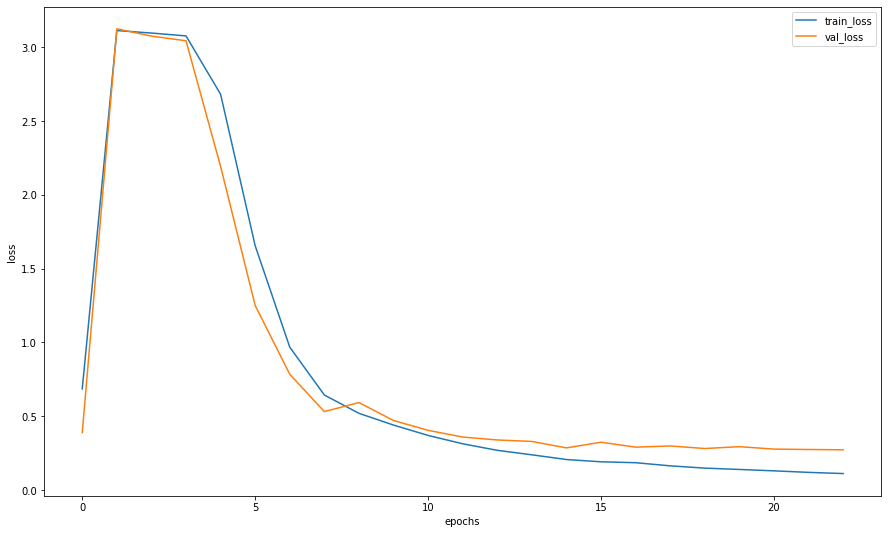

In [28]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")

plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [34]:
model.load_state_dict(torch.load('best_val.pth')) # загружаем веса эпохи с лучшей loss val

<All keys matched successfully>

In [35]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [36]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [37]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [38]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [39]:
from sklearn.metrics import f1_score

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

f1_score(actual_labels, y_pred, average='weighted')

0.9380952380952381

К сожалению, так и не удалось посчитать F-меру также, как считает ее Kaggle. Kaggle при данной архитектуре и гиперпараметрах выдает score **0.97555**


### Создаем submit

In [41]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [42]:
import pandas as pd
# my_submit = pd.read_csv("labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [43]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)